### Conditional GAN (CGAN)
we haven’t been able to control the type of image
we would like to generate—for example, a male or female
face, or a large or small brick. We can sample a random
point from the latent space, but we do not have the ability
to easily understand what kind of image will be produced
given the choice of latent variable.

we shall turn our attention
to building a GAN where we are able to control the output
—a so called conditional GAN

The key difference between a standard GAN and a CGAN is
that in a CGAN we pass in extra information to the
generator and critic relating to the label. In the generator,
this is simply appended to the latent space sample as a one-hot encoded vector. In the critic, we add the label
information as extra channels to the RGB image. We do this
by repeating the one-hot encoded vector to fill the same
shape as the input images.

CGANs work because the critic now has access to extra
information regarding the content of the image, so the
generator must ensure that its output agrees with the
provided label, in order to keep fooling the critic

In [ ]:
from tensorflow.keras import layers, metrics, losses, optimizers,callbacks, utils,models
import tensorflow as tf
import numpy as np
from utils import sample_batch, display
import pandas as pd

In [ ]:
IMAGE_SIZE = 64
CHANNELS = 3
NUM_CLASSES = 2
BATCH_SIZE = 128
Z_DIM = 32
LEARNING_RATE = 0.00005
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 20
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
LABEL = "Blond_Hair"
NUM_FEATURES=64

In [ ]:
# Load the label dataset
attributes = pd.read_csv("C:\\Users\\Whitebox\\Desktop\\envs_and_git_repos\\generative_models\\data\\celeba\\img_align_celeba\\list_attr_celeba.csv")
print(attributes.columns)
attributes.head()

In [ ]:
# Load the data
labels = attributes[LABEL].tolist()
int_labels = [x if x == 1 else 0 for x in labels]

In [ ]:
folder = 'C:\\Users\\Whitebox\\Desktop\\envs_and_git_repos\\generative_models\\data\\celeba\\img_align_celeba\\img_align_celeba'

In [ ]:
train_data = utils.image_dataset_from_directory(
    folder
    ,labels=int_labels
    ,color_mode='rgb'
    ,image_size=(IMAGE_SIZE,IMAGE_SIZE)
    ,batch_size=BATCH_SIZE
    ,interpolation='bilinear'
    ,shuffle=True
    ,seed=42
)

def preprocess(img):
    img = (tf.cast(img,'float32') - 127.5)/127.5
    return img

train = train_data.map(
    lambda x, y: (preprocess(x), tf.one_hot(y, depth=NUM_CLASSES))
)

In [ ]:
train_sample = sample_batch(train)
display(train_sample)

#### Critic
The only change we need to make to the architecture is to
concatenate the label information to the existing inputs of
the generator and the critic

In [39]:
critic_input = layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS))
label_input = layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,NUM_CLASSES))

x = layers.Concatenate(axis=-1)([critic_input,label_input])

x = layers.Conv2D(filters=NUM_FEATURES,kernel_size=4,strides=2,padding='same')(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(filters=NUM_FEATURES*2,kernel_size=4,strides=2,padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(filters=NUM_FEATURES*2,kernel_size=4,strides=2,padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(filters=NUM_FEATURES*2,kernel_size=4,strides=2,padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(filters=1,kernel_size=4,strides=1,padding='valid')(x)
critic_output = layers.Flatten()(x)

critic = models.Model([critic_input,label_input],critic_output)
critic.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 concatenate_2 (Concatenate)    (None, 64, 64, 5)    0           ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 32, 32, 64)   5184        ['concatenate_2[0][0]']    

#### Generator

In [40]:
generator_input = layers.Input(shape=(Z_DIM,))
label_input = layers.Input(shape=(NUM_CLASSES,))
x = layers.Concatenate(axis=-1)([generator_input,label_input])

x = layers.Reshape(target_shape=(1,1,Z_DIM+NUM_CLASSES))(x)
x = layers.Conv2DTranspose(filters=512,kernel_size=4,strides=1,padding='valid',use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(filters=256,kernel_size=4,strides=2,padding='same',use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(filters=128,kernel_size=4,strides=2,padding='same',use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(filters=64,kernel_size=4,strides=2,padding='same',use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

generator_output = layers.Conv2DTranspose(CHANNELS,kernel_size=4,strides=2,
padding='same',activation='tanh')(x)

generator = models.Model([generator_input,label_input],generator_output)
generator.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 concatenate_3 (Concatenate)    (None, 34)           0           ['input_7[0][0]',                
                                                                  'input_8[0][0]']                
                                                                                                  
 reshape_1 (Reshape)            (None, 1, 1, 34)     0           ['concatenate_3[0][0]']    

In [ ]:
class ConditionalWGAN(models.Model):
    def __init__(self,critic,generator,latent_dim,critic_steps,gp_weight):
        super(ConditionalWGAN,self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self,c_optimizer, g_optimizer):
        super(ConditionalWGAN, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name='wass_loss')
        self.c_gp_metric = metrics.Mean(name='c_gp')
        self.c_loss_metric = metrics.Mean(name='c_loss')
        self.g_loss_metric = metrics.Mean(name='g_loss')

    @property
    def metrics(self):
        return [self.c_wass_loss_metric,
                self.c_gp_metric,
                self.c_loss_metric,
                self.g_loss_metric]

    def gradient_penalty(self, batch_size, real_images, fake_images, image_one_hot_labels):
        alpha = tf.random.normal([batch_size,1,1,1],0.0,1.0)
        diff = real_images - fake_images
        interpolated = diff + alpha * diff
        
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic([interpolated,image_one_hot_labels],training=True)
        
        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads),axis=[1,2,3]))
        #Ensures gradient is close to 1
        gp = tf.reduce_mean((norm - 1.0)**2)
        return gp

    def train_step(self, data):
        real_images, one_hot_labels = data

        image_one_hot_labels = one_hot_labels[:,None,None,:]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels,repeats=IMAGE_SIZE,axis=1
        )
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels,repeats=IMAGE_SIZE,axis=2
        )

        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(
                [batch_size,self.latent_dim]
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator([random_latent_vectors,one_hot_labels],training=True)
                fake_predictions = self.critic([fake_images,image_one_hot_labels],training=True)
                real_predictions = self.critic([real_images,image_one_hot_labels],training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(real_predictions)
                c_gp_penalty = self.gradient_penalty(batch_size,real_images,fake_images,image_one_hot_labels)
                c_loss = c_wass_loss + c_gp_penalty * self.gp_weight
            
            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(zip(c_gradient,self.critic.trainable_variables))
        
        random_latent_vectors = tf.random.normal(
            [batch_size,self.latent_dim]
        )

        with tf.GradientTape() as tape:
            fake_images = self.generator([random_latent_vectors,one_hot_labels],training=True)
            fake_predictions = self.critic([fake_images,image_one_hot_labels],training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss,self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient,self.generator.trainable_variables))

        self.c_loss_metric.update_state(c_loss)
        self.c_gp_metric.update_state(c_gp_penalty)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.g_loss_metric.update_state(g_loss)

        return {m.name:m.result() for m in self.metrics}

In [ ]:
# Create a GAN
cgan = ConditionalWGAN(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [ ]:
# Compile the GAN
cgan.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [17]:
call_back_interval = 200

In [20]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim,call_back_interval):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.call_back_interval = call_back_interval

    def on_epoch_end(self, epoch, logs=None):
        if epoch%self.call_back_interval == 0:
            random_latent_vectors = tf.random.normal(
                shape=(self.num_img, self.latent_dim)
            )
            # 0 label
            zero_label = np.repeat([[1, 0]], self.num_img, axis=0)
            generated_images = self.model.generator(
                [random_latent_vectors, zero_label]
            )
            generated_images = generated_images * 127.5 + 127.5
            generated_images = generated_images.numpy()
            display(
                generated_images,
                save_to="./output/generated_img_%03d_label_0.png" % (epoch),
                cmap=None,
            )

            # 1 label
            one_label = np.repeat([[0, 1]], self.num_img, axis=0)
            generated_images = self.model.generator(
                [random_latent_vectors, one_label]
            )
            generated_images = generated_images * 127.5 + 127.5
            generated_images = generated_images.numpy()
            display(
                generated_images,
                save_to="./output/generated_img_%03d_label_1.png" % (epoch),
                cmap=None,
            )

Epoch 1/2000
1/1 [==============================] - ETA: 0s - wass_loss: -13.3124 - c_gp: 0.2754 - c_loss: -10.5582 - g_loss: 45.6738
Saved to ./output/generated_img_000_label_0.png


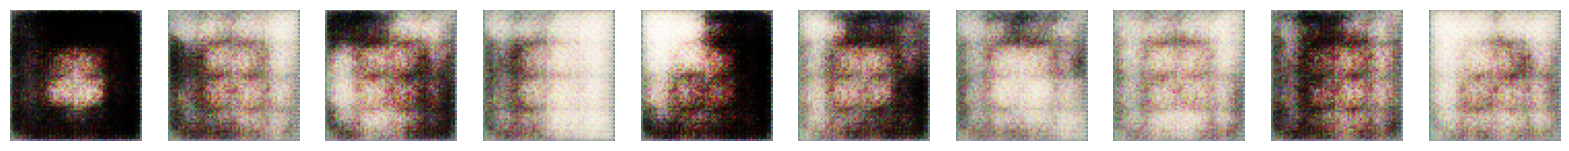


Saved to ./output/generated_img_000_label_1.png


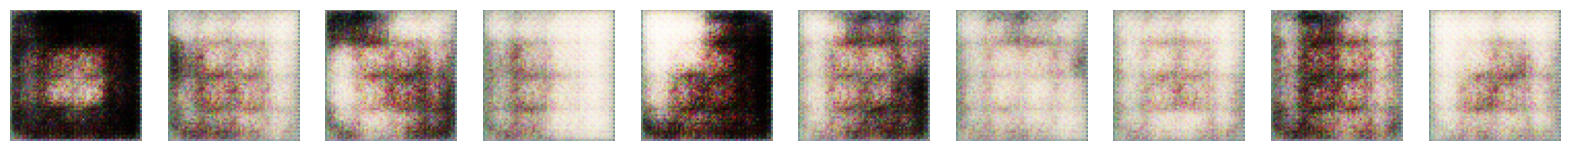

1/1 [==============================] - 10s 10s/step - wass_loss: -13.3124 - c_gp: 0.2754 - c_loss: -10.5582 - g_loss: 45.6738
Epoch 2/2000
1/1 [==============================] - 2s 2s/step - wass_loss: -11.3908 - c_gp: 0.2016 - c_loss: -9.3752 - g_loss: 53.6295
Epoch 3/2000
1/1 [==============================] - 2s 2s/step - wass_loss: -9.6786 - c_gp: 0.1858 - c_loss: -7.8209 - g_loss: 54.9760
Epoch 4/2000
1/1 [==============================] - 2s 2s/step - wass_loss: -12.7619 - c_gp: 0.1805 - c_loss: -10.9565 - g_loss: 67.6076
Epoch 5/2000
1/1 [==============================] - 2s 2s/step - wass_loss: -5.8743 - c_gp: 0.1944 - c_loss: -3.9302 - g_loss: 73.6692
Epoch 6/2000
1/1 [==============================] - 2s 2s/step - wass_loss: -10.2746 - c_gp: 0.1590 - c_loss: -8.6851 - g_loss: 67.1284
Epoch 7/2000
1/1 [==============================] - 4s 4s/step - wass_loss: -9.2271 - c_gp: 0.1753 - c_loss: -7.4740 - g_loss: 59.1195
Epoch 8/2000
1/1 [==============================] - 8s 8s/st

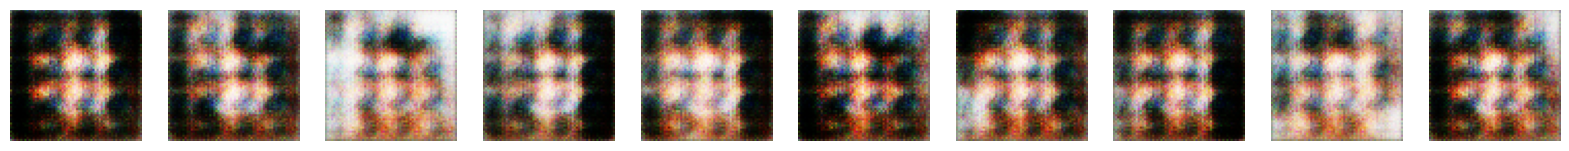


Saved to ./output/generated_img_200_label_1.png


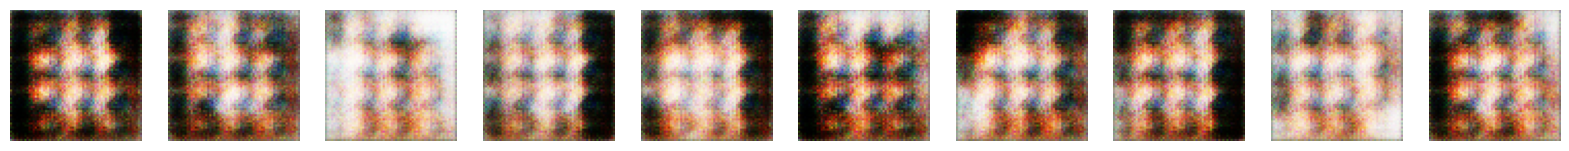

1/1 [==============================] - 3s 3s/step - wass_loss: -6.4394 - c_gp: 0.0799 - c_loss: -5.6408 - g_loss: 90.1619
Epoch 202/2000
1/1 [==============================] - 1s 822ms/step - wass_loss: 1.2635 - c_gp: 0.0693 - c_loss: 1.9567 - g_loss: 88.6905
Epoch 203/2000
1/1 [==============================] - 1s 829ms/step - wass_loss: -5.1848 - c_gp: 0.0645 - c_loss: -4.5396 - g_loss: 84.3345
Epoch 204/2000
1/1 [==============================] - 1s 801ms/step - wass_loss: -0.7554 - c_gp: 0.0554 - c_loss: -0.2017 - g_loss: 84.2889
Epoch 205/2000
1/1 [==============================] - 1s 808ms/step - wass_loss: -7.1749 - c_gp: 0.0549 - c_loss: -6.6257 - g_loss: 84.0952
Epoch 206/2000
1/1 [==============================] - 1s 878ms/step - wass_loss: -0.9320 - c_gp: 0.0598 - c_loss: -0.3337 - g_loss: 80.1657
Epoch 207/2000
1/1 [==============================] - 1s 932ms/step - wass_loss: -3.7634 - c_gp: 0.0429 - c_loss: -3.3346 - g_loss: 74.8720
Epoch 208/2000
1/1 [====================

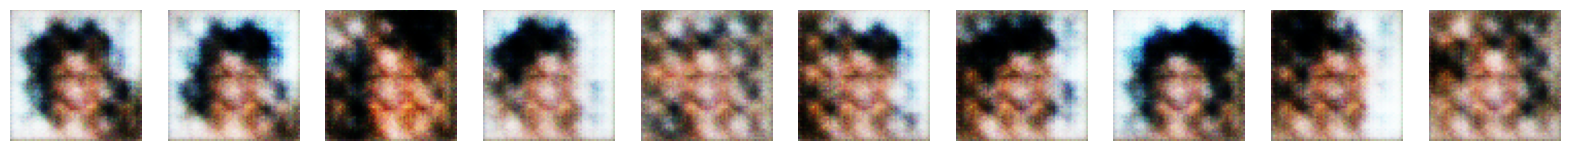


Saved to ./output/generated_img_400_label_1.png


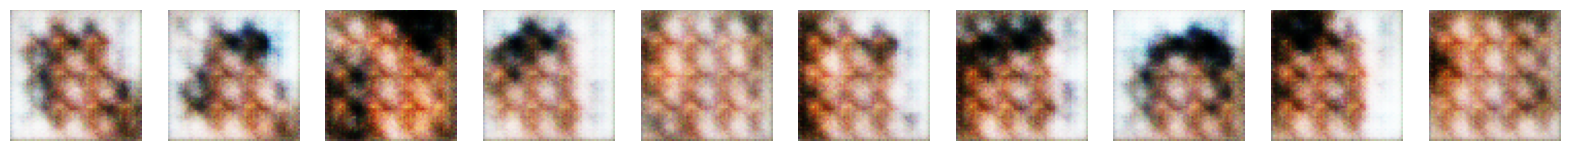

1/1 [==============================] - 3s 3s/step - wass_loss: -4.1561 - c_gp: 0.0552 - c_loss: -3.6039 - g_loss: 53.7746
Epoch 402/2000
1/1 [==============================] - 1s 816ms/step - wass_loss: -4.1584 - c_gp: 0.0372 - c_loss: -3.7869 - g_loss: 54.7678
Epoch 403/2000
1/1 [==============================] - 1s 835ms/step - wass_loss: -6.5111 - c_gp: 0.0354 - c_loss: -6.1569 - g_loss: 58.3932
Epoch 404/2000
1/1 [==============================] - 1s 1000ms/step - wass_loss: -4.4647 - c_gp: 0.0317 - c_loss: -4.1476 - g_loss: 61.9064
Epoch 405/2000
1/1 [==============================] - 1s 834ms/step - wass_loss: -6.8985 - c_gp: 0.0225 - c_loss: -6.6736 - g_loss: 56.4919
Epoch 406/2000
1/1 [==============================] - 1s 863ms/step - wass_loss: -4.5501 - c_gp: 0.0206 - c_loss: -4.3436 - g_loss: 63.7040
Epoch 407/2000
1/1 [==============================] - 1s 958ms/step - wass_loss: -3.0438 - c_gp: 0.0278 - c_loss: -2.7661 - g_loss: 71.0138
Epoch 408/2000
1/1 [=================

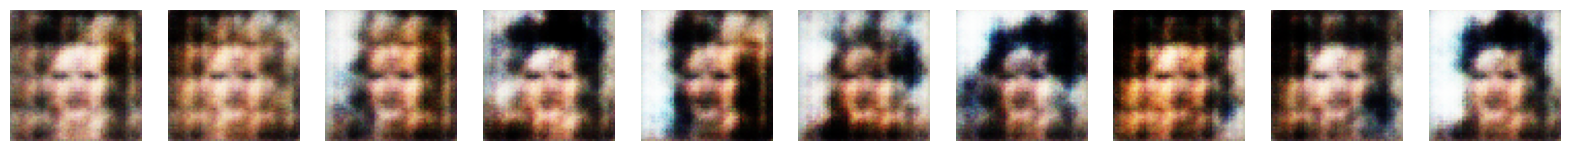


Saved to ./output/generated_img_600_label_1.png


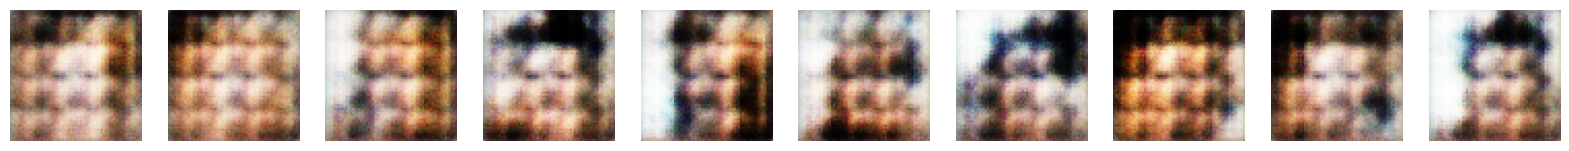

1/1 [==============================] - 2s 2s/step - wass_loss: -4.6076 - c_gp: 0.0245 - c_loss: -4.3621 - g_loss: 61.0828
Epoch 602/2000
1/1 [==============================] - 1s 1s/step - wass_loss: -8.7881 - c_gp: 0.0304 - c_loss: -8.4838 - g_loss: 59.3391
Epoch 603/2000
1/1 [==============================] - 1s 814ms/step - wass_loss: -5.5588 - c_gp: 0.0333 - c_loss: -5.2262 - g_loss: 53.2167
Epoch 604/2000
1/1 [==============================] - 1s 820ms/step - wass_loss: -6.3811 - c_gp: 0.0388 - c_loss: -5.9929 - g_loss: 58.2176
Epoch 605/2000
1/1 [==============================] - 1s 817ms/step - wass_loss: -5.0500 - c_gp: 0.0359 - c_loss: -4.6907 - g_loss: 48.4238
Epoch 606/2000
1/1 [==============================] - 1s 867ms/step - wass_loss: -4.9602 - c_gp: 0.0334 - c_loss: -4.6258 - g_loss: 37.1721
Epoch 607/2000
1/1 [==============================] - 1s 779ms/step - wass_loss: -1.7633 - c_gp: 0.0326 - c_loss: -1.4372 - g_loss: 38.9456
Epoch 608/2000
1/1 [=====================

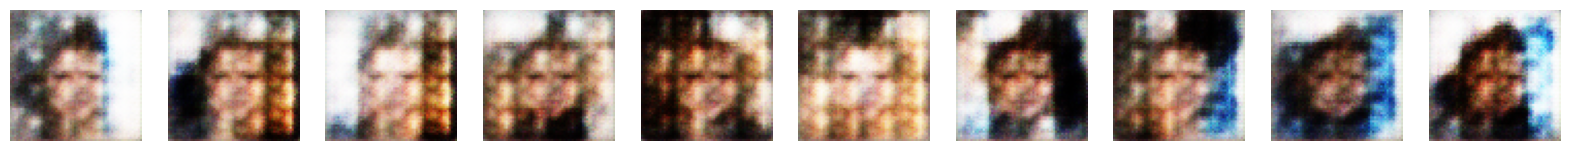


Saved to ./output/generated_img_800_label_1.png


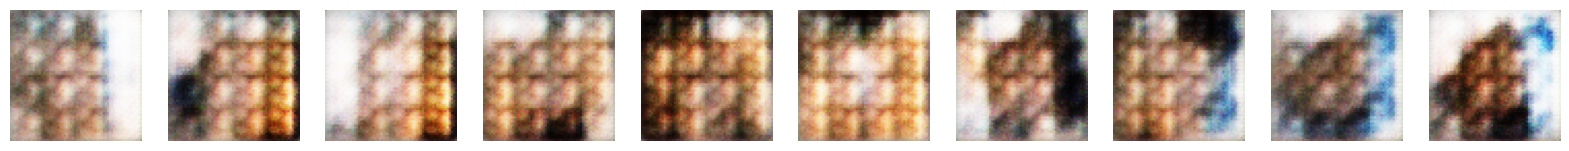

1/1 [==============================] - 2s 2s/step - wass_loss: -2.4324 - c_gp: 0.0549 - c_loss: -1.8830 - g_loss: 11.9176
Epoch 802/2000
1/1 [==============================] - 1s 857ms/step - wass_loss: -1.1700 - c_gp: 0.0282 - c_loss: -0.8878 - g_loss: 15.3151
Epoch 803/2000
1/1 [==============================] - 1s 1s/step - wass_loss: -4.8347 - c_gp: 0.0245 - c_loss: -4.5901 - g_loss: 16.3219
Epoch 804/2000
1/1 [==============================] - 1s 1s/step - wass_loss: -5.2545 - c_gp: 0.0240 - c_loss: -5.0140 - g_loss: 16.3940
Epoch 805/2000
1/1 [==============================] - 1s 948ms/step - wass_loss: -3.0220 - c_gp: 0.0263 - c_loss: -2.7591 - g_loss: 12.7299
Epoch 806/2000
1/1 [==============================] - 1s 862ms/step - wass_loss: -4.7646 - c_gp: 0.0304 - c_loss: -4.4602 - g_loss: 16.4252
Epoch 807/2000
1/1 [==============================] - 1s 845ms/step - wass_loss: -7.4521 - c_gp: 0.0292 - c_loss: -7.1599 - g_loss: 18.3924
Epoch 808/2000
1/1 [========================

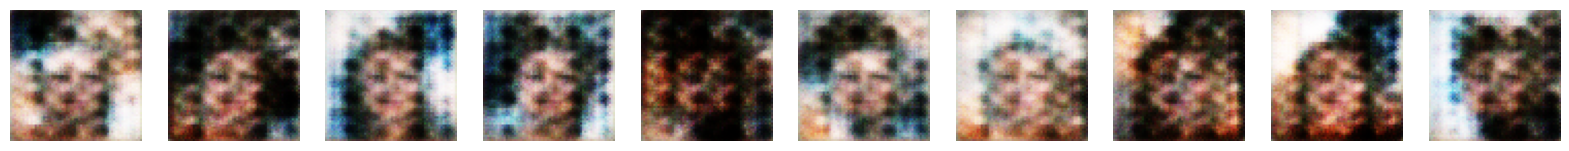


Saved to ./output/generated_img_1000_label_1.png


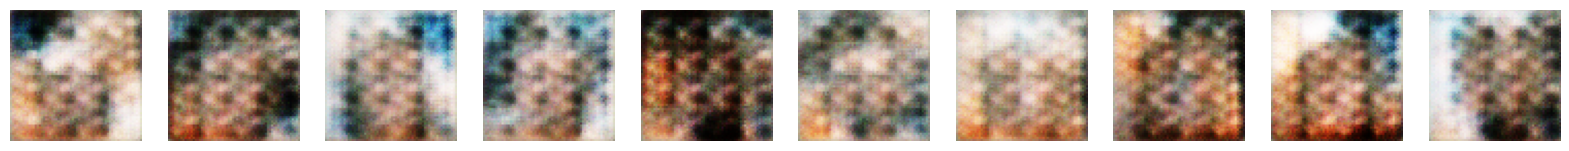

1/1 [==============================] - 4s 4s/step - wass_loss: -6.8070 - c_gp: 0.0323 - c_loss: -6.4844 - g_loss: -29.8629
Epoch 1002/2000
1/1 [==============================] - 1s 895ms/step - wass_loss: -4.1411 - c_gp: 0.0381 - c_loss: -3.7606 - g_loss: -30.0028
Epoch 1003/2000
1/1 [==============================] - 1s 886ms/step - wass_loss: -6.7973 - c_gp: 0.0465 - c_loss: -6.3324 - g_loss: -27.1641
Epoch 1004/2000
1/1 [==============================] - 1s 1s/step - wass_loss: -9.9693 - c_gp: 0.0595 - c_loss: -9.3743 - g_loss: -33.3759
Epoch 1005/2000
1/1 [==============================] - 1s 848ms/step - wass_loss: -6.7559 - c_gp: 0.0651 - c_loss: -6.1045 - g_loss: -32.5191
Epoch 1006/2000
1/1 [==============================] - 1s 820ms/step - wass_loss: -6.2047 - c_gp: 0.0667 - c_loss: -5.5380 - g_loss: -34.3066
Epoch 1007/2000
1/1 [==============================] - 1s 887ms/step - wass_loss: -10.0321 - c_gp: 0.0854 - c_loss: -9.1780 - g_loss: -37.9053
Epoch 1008/2000
1/1 [======

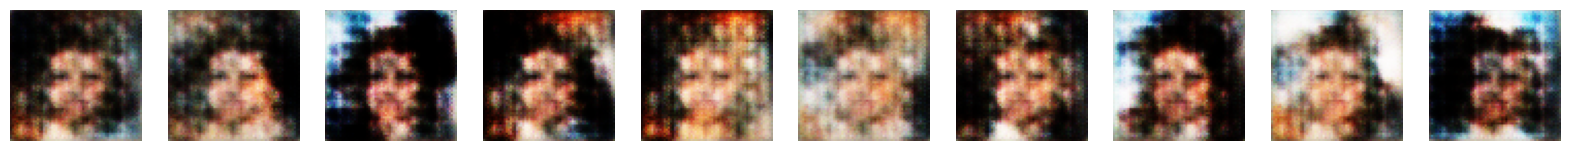


Saved to ./output/generated_img_1200_label_1.png


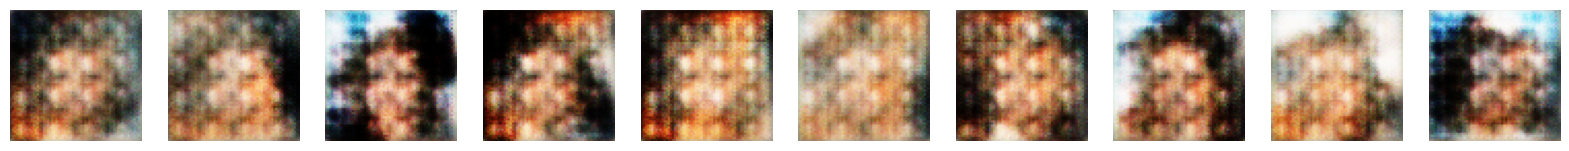

1/1 [==============================] - 3s 3s/step - wass_loss: -5.2780 - c_gp: 0.0308 - c_loss: -4.9701 - g_loss: -25.9449
Epoch 1202/2000
1/1 [==============================] - 1s 915ms/step - wass_loss: -4.0505 - c_gp: 0.0350 - c_loss: -3.7009 - g_loss: -34.3118
Epoch 1203/2000
1/1 [==============================] - 1s 922ms/step - wass_loss: -3.8961 - c_gp: 0.0436 - c_loss: -3.4598 - g_loss: -32.6144
Epoch 1204/2000
1/1 [==============================] - 1s 924ms/step - wass_loss: -5.5033 - c_gp: 0.0413 - c_loss: -5.0902 - g_loss: -25.2402
Epoch 1205/2000
1/1 [==============================] - 1s 819ms/step - wass_loss: -3.2163 - c_gp: 0.0366 - c_loss: -2.8505 - g_loss: -24.7253
Epoch 1206/2000
1/1 [==============================] - 1s 832ms/step - wass_loss: -5.3059 - c_gp: 0.0306 - c_loss: -5.0004 - g_loss: -18.5978
Epoch 1207/2000
1/1 [==============================] - 1s 834ms/step - wass_loss: -2.5209 - c_gp: 0.0302 - c_loss: -2.2184 - g_loss: -23.7528
Epoch 1208/2000
1/1 [====

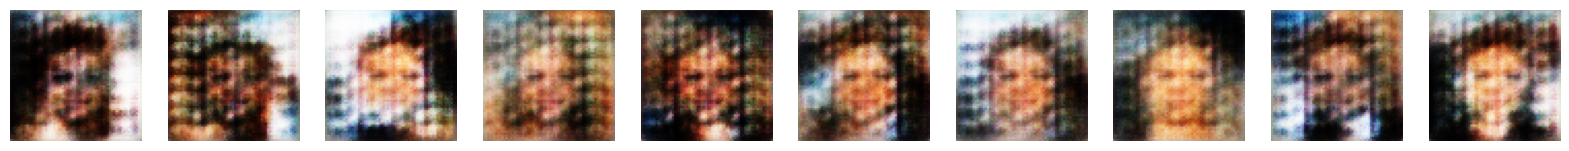


Saved to ./output/generated_img_1400_label_1.png


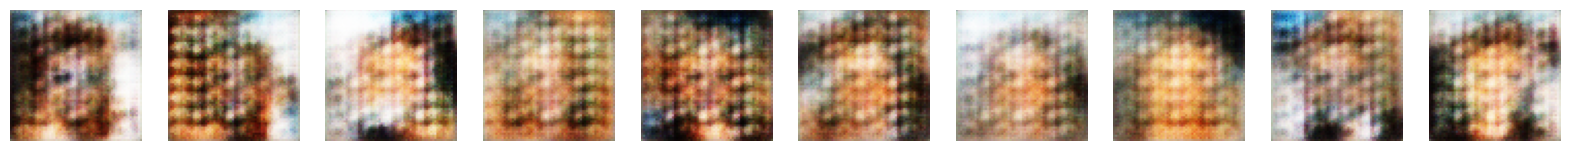

1/1 [==============================] - 3s 3s/step - wass_loss: -6.4642 - c_gp: 0.0452 - c_loss: -6.0120 - g_loss: 18.9549
Epoch 1402/2000
1/1 [==============================] - 1s 882ms/step - wass_loss: -4.6653 - c_gp: 0.0330 - c_loss: -4.3354 - g_loss: 19.9804
Epoch 1403/2000
1/1 [==============================] - 1s 873ms/step - wass_loss: -5.6759 - c_gp: 0.0237 - c_loss: -5.4388 - g_loss: 24.9672
Epoch 1404/2000
1/1 [==============================] - 1s 1s/step - wass_loss: -2.7909 - c_gp: 0.0207 - c_loss: -2.5834 - g_loss: 26.9429
Epoch 1405/2000
1/1 [==============================] - 1s 845ms/step - wass_loss: -2.8194 - c_gp: 0.0242 - c_loss: -2.5773 - g_loss: 31.5552
Epoch 1406/2000
1/1 [==============================] - 1s 931ms/step - wass_loss: -3.3624 - c_gp: 0.0319 - c_loss: -3.0434 - g_loss: 30.8441
Epoch 1407/2000
1/1 [==============================] - 1s 927ms/step - wass_loss: -7.1291 - c_gp: 0.0347 - c_loss: -6.7822 - g_loss: 38.1744
Epoch 1408/2000
1/1 [==============

In [21]:
history = cgan.fit(
    train,
    epochs=EPOCHS * 100,
    steps_per_epoch=1,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM,call_back_interval=
        
        
        call_back_interval),
    ],
)